### Bienvenidos al cuaderno utilizado para mi proyecto:

```
Exploración: Clasificador Variacional Cuántico (VQC) y Análisis de Componentes Principales (PCA) para la clasificación de imágenes
```

## Este código realiza dos tareas principales:

### 1. Reducción de dimensionalidad y red neuronal:
   - Se carga el dataset `MNIST` y se preprocesa.
   - Se crea una tubería (Pipeline) de scikit-learn que imputa valores faltantes, reduce la dimensionalidad mediante `PCA` y normaliza los datos (`MinMaxScaler`).
   - Se define, compila y entrena un modelo de red neuronal clásico con Keras utilizando los datos reducidos, para su comparación con el VQC.
   - Se evalúa el modelo mostrando algunas imágenes con sus etiquetas predichas, se calcula y muestra la matriz de confusión, y se reporta la precisión (`Top-1 Accuracy`).

### 2. Clasificador cuántico variacional (VQC):
   - Se construye un clasificador cuántico utilizando Qiskit Machine Learning.
   - Se utilizará un `ZZFeatureMap` para codificar los datos,  `RealAmplitudes` como nuestro ansatz, `cross-entropy` como nuestra función error a minimizar, y `COBYLA` como nuestro optimizador.
   - Se evalúan los resultados mediante matriz de confusión y se calcula la precisión (Top-1 Accuracy).

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

# Configuración de visualización para gráficos
plt.rcParams["figure.figsize"] = (10, 7)

# Definición de constantes
NUM_FEATURES: int = 4  # Número de características que usaremos luego de PCA
NUM_EPOCHS: int = 20  # Número de épocas para entrenar el modelo de red neuronal
NUMS_TO_INCLUDE: list = [0,1,2]

# Create dynamic mappings based on the NUMS_TO_INCLUDE list
label_to_index = {label: idx for idx, label in enumerate(NUMS_TO_INCLUDE)}
index_to_label = {idx: label for idx, label in enumerate(NUMS_TO_INCLUDE)}

### Función para crear y compilar la red neuronal de `Keras`

In [2]:
def create_model(input_shape: tuple):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, activation="relu", input_shape=input_shape))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Dinámico según la cantidad de clases en NUMS_TO_INCLUDE
    model.add(tf.keras.layers.Dense(len(NUMS_TO_INCLUDE), activation="softmax"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

### Creación de la tubería (`Pipeline`) de preprocesamiento
#### Se definen los pasos de la tubería:
1. Llenar valores faltantes utilizando la media (en caso de haber)
2. Reducir la dimensionalidad a `NUM_FEATURES` mediante `PCA`
3. Escalar los datos en el rango `[0,1]` utilizando `MinMaxScaler`

In [3]:
estimators = [
    ("handle_missing_values", SimpleImputer(strategy="mean")),
    ("reduce_dim", PCA(NUM_FEATURES)),
    ("scale_to_pi", MinMaxScaler()),
]

pipe = Pipeline(estimators)
pipe  # La variable 'pipe' contiene la tubería configurada

Pipeline(steps=[('handle_missing_values', SimpleImputer()),
                ('reduce_dim', PCA(n_components=4)),
                ('scale_to_pi', MinMaxScaler())])

### Carga y preprocesamiento del dataset `MNIST`

In [4]:
# Carga del dataset MNIST; se dividen en conjunto de entrenamiento y prueba

(train_X, train_y), (test_X, test_y) = mnist.load_data()

mask_tr = np.isin(train_y, NUMS_TO_INCLUDE)
mask_tst = np.isin(test_y, NUMS_TO_INCLUDE)
train_X, train_y, test_X, test_y = (
    train_X[mask_tr],
    train_y[mask_tr],
    test_X[mask_tst],
    test_y[mask_tst],
)

# Convertir las etiquetas originales a índices (por ejemplo, 6 -> 0, 4 -> 1)
train_y_indices = np.array([label_to_index[label] for label in train_y])
test_y_indices = np.array([label_to_index[label] for label in test_y])

# Convertir las etiquetas a formato one-hot para la clasificación
train_y_cat = to_categorical(train_y_indices, num_classes=len(NUMS_TO_INCLUDE))
test_y_cat = to_categorical(test_y_indices, num_classes=len(NUMS_TO_INCLUDE))

# Reestructurar las imágenes de 2D a 1D para aplicar PCA y otros preprocesamientos
reshaped_train_X = train_X.reshape(train_X.shape[0], -1)
reshaped_test_X = test_X.reshape(test_X.shape[0], -1)

### Visualización de imágenes aleatorias del conjunto de entrenamiento

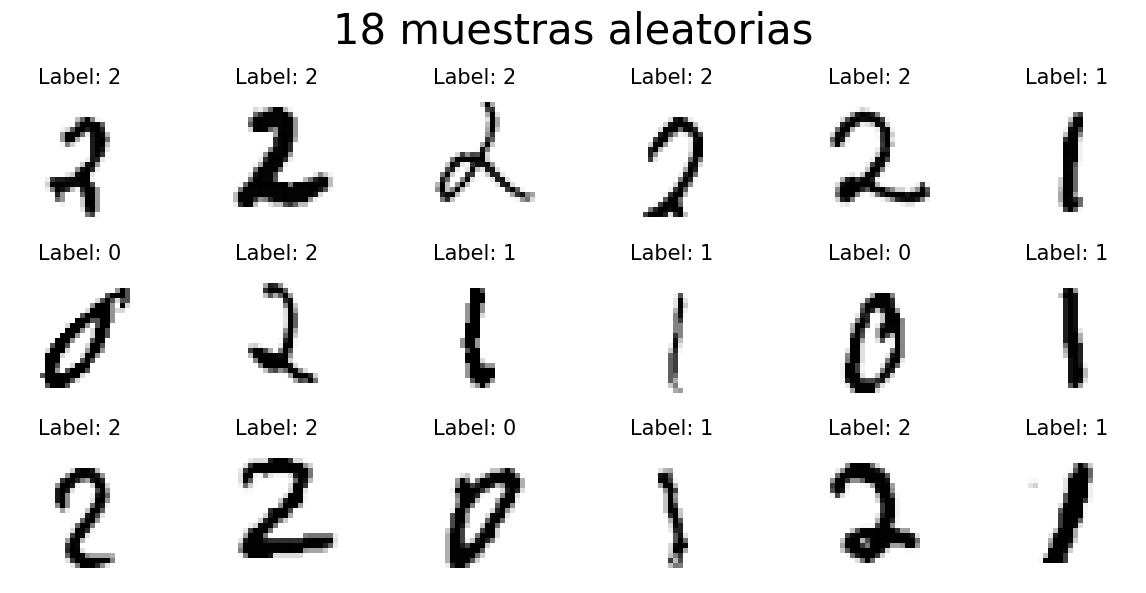

In [5]:
# Se muestran muestras aleatorias de las imágenes de entrenamiento junto con sus etiquetas reales
cols = 6
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

for ax in axes.flat:
    idx = random.randint(0, len(train_X) - 1)  # Seleccionar un índice aleatorio válido
    ax.imshow(train_X[idx], cmap="Greys")  # Mostrar la imagen en escala de grises
    # Mostrar la etiqueta real (convertida desde one-hot) en el título
    ax.set_title(f"Label: {train_y[idx]}", size=15)
    ax.axis("off")  # Ocultar ejes para una mejor visualización

fig.suptitle(f"{cols * rows} muestras aleatorias", size=30)
plt.tight_layout()
plt.show()

### Preprocesamiento de datos utilizando la tubería (Pipeline)

In [6]:
# Aplicar la transformación (PCA, escalado, etc.)
p_train_X = pipe.fit_transform(reshaped_train_X, train_y_indices)
p_test_X = pipe.transform(reshaped_test_X)

### Entrenamiento de la red neuronal

In [7]:
%%time 
# Crear el modelo utilizando el número de características reducido (NUM_FEATURES)
model = create_model((NUM_FEATURES,))
# Entrenar el modelo con los datos preprocesados y las etiquetas one-hot
model.fit(p_train_X, train_y_cat, epochs=NUM_EPOCHS)

Epoch 1/20


/Users/jjmtz/anaconda3/envs/quno/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.7849 - loss: 0.6204
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.9578 - loss: 0.1254
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.9613 - loss: 0.1109
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.9631 - loss: 0.1027
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.9666 - loss: 0.0992
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.9665 - loss: 0.0973
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.9648 - loss: 0.0998
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.9677 - loss: 0.0946
Epoch 9/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.9651 - loss: 0.0911
Epoch 10/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.9667 - loss: 0.0940
Epoch 11/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 0.9670 - loss: 0.0904
Epoch 12/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 

### Predicciones con el modelo entrenado

In [8]:
# Se realizan predicciones sobre el conjunto de prueba preprocesado
y_hat = model.predict(p_test_X)
y_h = np.argmax(y_hat, axis=1)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


### Evaluación del modelo: Matriz de Confusión y Precisión (`Top-1 Accuracy`)

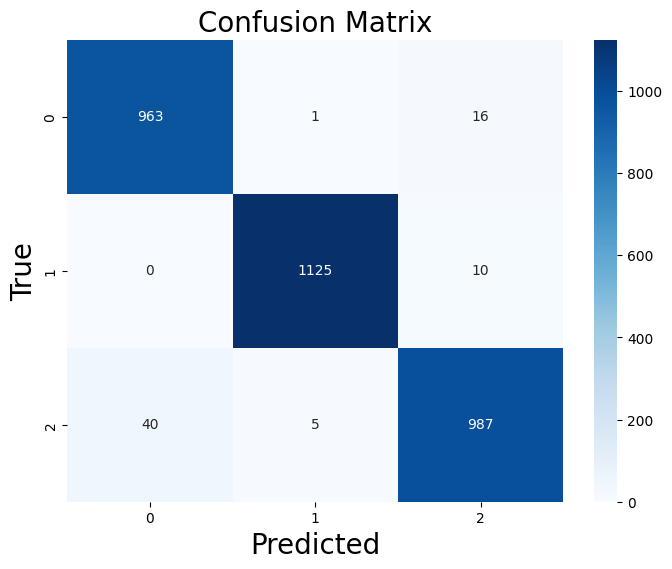

Top-1 Accuracy (R1 score): 97.71%


In [9]:
# Calcular la matriz de confusión comparando las etiquetas reales y las predichas
conf_matrix = confusion_matrix(test_y_indices, y_h)

# Graficar la matriz de confusión utilizando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=NUMS_TO_INCLUDE,
    yticklabels=NUMS_TO_INCLUDE,
)
plt.title("Confusion Matrix", size=20)
plt.xlabel("Predicted", size=20)
plt.ylabel("True", size=20)
plt.show()

# Calcular la precisión (Top-1 Accuracy)
top_1_accuracy = np.mean(y_h == test_y_indices)
print(f"Top-1 Accuracy (R1 score): {top_1_accuracy * 100:.2f}%")

### Visualización de muestras del conjunto de prueba con sus predicciones

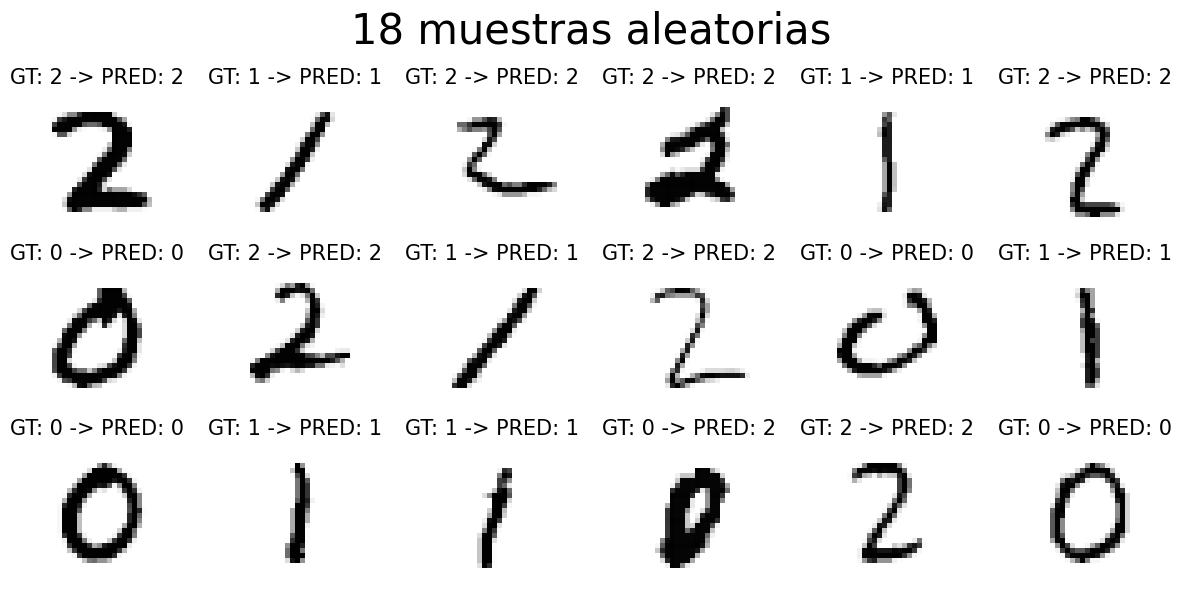

In [10]:
# Se muestran muestras aleatorias del conjunto de prueba junto con la etiqueta real y la predicción
cols = 6
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

for ax in axes.flat:
    idx = random.randint(0, len(test_X) - 1)  # Seleccionar un índice aleatorio válido
    ax.imshow(test_X[idx], cmap="Greys")    # Mostrar la imagen en escala de grises
    # Título que indica la etiqueta verdadera (GT) y la predicha (PRED)
    ax.set_title(f"GT: {test_y[idx]} -> PRED: {np.argmax(y_hat, axis=1)[idx]}", size=15)
    ax.axis("off")  # Ocultar ejes

fig.suptitle(f"{cols * rows} muestras aleatorias", size=30)
plt.tight_layout()
plt.show()

## En este bloque se realiza la implementación de un clasificador cuántico variacional (VQC)
### Los pasos son los siguientes:

1. Se importan las librerías de Qiskit y otras necesarias para la computación cuántica y la optimización.
2. Se configuran parámetros para el entrenamiento cuántico (número de muestras, épocas cuánticas, etc.).
3. Se define un callback (callback_graph) que actualiza un gráfico en vivo de la función objetivo durante el entrenamiento.
4. Se configuran el feature map, el ansatz y el optimizador para el clasificador cuántico.
5. Se crea una instancia de la clase y se entrena el modelo cuántico.
6. Finalmente, se evalúa el modelo cuántico mediante la matriz de confusión y se calcula la precisión (Top-1 Accuracy).

In [11]:
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from IPython.display import clear_output
from qiskit.primitives import StatevectorSampler

# Parámetros para la parte cuántica
NUM_SAMPLES: int = 50      # Número de muestras para entrenamiento cuántico
NUM_Q_EPOCHS: int = 170        # Número de iteraciones/épocas para el optimizador cuántico
NUM_REPS: int = 4    # Número de repeticiones en el circuito cuántico
ENTANGLEMENT: str = "linear" # Patrón de enredamiento (lineal)

# Asignación de los datos de prueba para la parte cuántica
q_test_X = p_test_X
q_test_y = test_y

q_train_X = p_train_X
q_train_y = train_y_indices

# Callback para visualizar la evolución de la función objetivo
def callback_graph(weights, obj_func_eval) -> None:
    """
    Función de callback para el entrenamiento del VQC.
    Actualiza un gráfico en vivo que muestra el valor de la función objetivo por iteración.

    Parámetros:
        weights: Pesos actuales del modelo (no se utilizan directamente en este callback).
        obj_func_eval: Valor de la función objetivo en la iteración actual.
    """
    clear_output(wait=True)  # Limpia la salida para actualizar el gráfico
    objective_func_vals.append(obj_func_eval)  # Almacena el valor de la función objetivo
    plt.title("Valor de la función objetivo vs Iteración")
    plt.xlabel("Iteración")
    plt.ylabel("Valor de la función objetivo")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Sampler basado en statevector para la simulación del circuito cuántico
sampler = StatevectorSampler()

# Definir un feature map de tipo ZZ, que transforma los datos clásicos en estados cuánticos
feature_map = ZZFeatureMap(
    q_test_X.shape[1],
    reps=NUM_REPS,
    entanglement=ENTANGLEMENT,  # Patrón de entrelazamieto
    insert_barriers=True,  # Inserta barreras para una mejor visualización del circuito
)

# Definir el ansatz cuántico base con parámetros configurables
ansatz = RealAmplitudes(
    num_qubits=q_test_X.shape[1],
    reps=NUM_REPS,
    entanglement=ENTANGLEMENT,
    insert_barriers=True,
)

# Configurar el optimizador (COBYLA) para minimizar la función objetivo del VQC
optimizer = COBYLA(
    maxiter=NUM_Q_EPOCHS,
    max_evals_grouped=20,
)

# Parámetros del VQC, incluyendo el optimizador, callback, función de pérdida, sampler, feature map, ansatz mejorado y salida esperada
vqc_params = {
    "optimizer": optimizer,
    "callback": callback_graph,
    "loss": "cross_entropy",
    "sampler": sampler,
    "feature_map": feature_map,
    "ansatz": ansatz,
    "output_shape": len(NUMS_TO_INCLUDE),
}

# Crear una instancia del clasificador cuántico 
vqc = VQC(**vqc_params)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


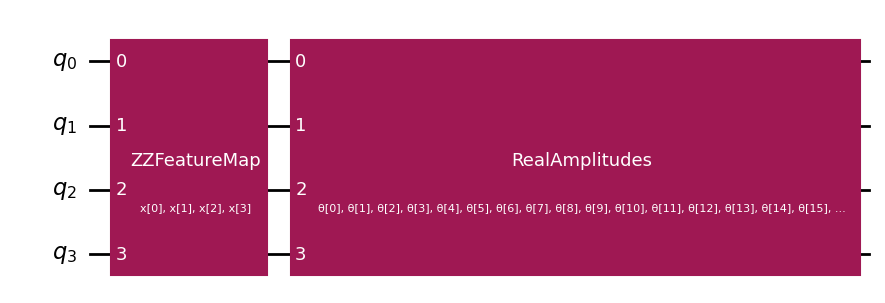

In [12]:
# Se dibuja el circuito para su visualización
vqc.circuit.draw("mpl")

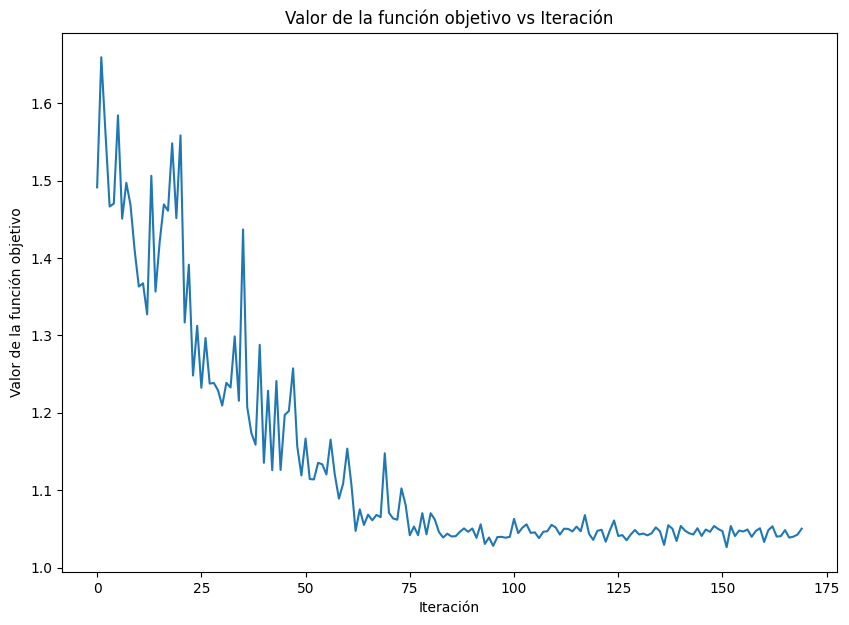

CPU times: user 50 s, sys: 958 ms, total: 50.9 s
Wall time: 51.3 s


In [13]:
%%time
objective_func_vals = [] # Lista para almacenar los valores de la función objetivo en cada iteración
model = vqc.fit(
    X=q_train_X[:NUM_SAMPLES], 
    y=q_train_y[:NUM_SAMPLES], 
)

### Predicción utilizando el clasificador cuántico entrenado

In [14]:
predictions = np.argmax(vqc.predict_proba(q_test_X[:NUM_SAMPLES*10]), axis=1)

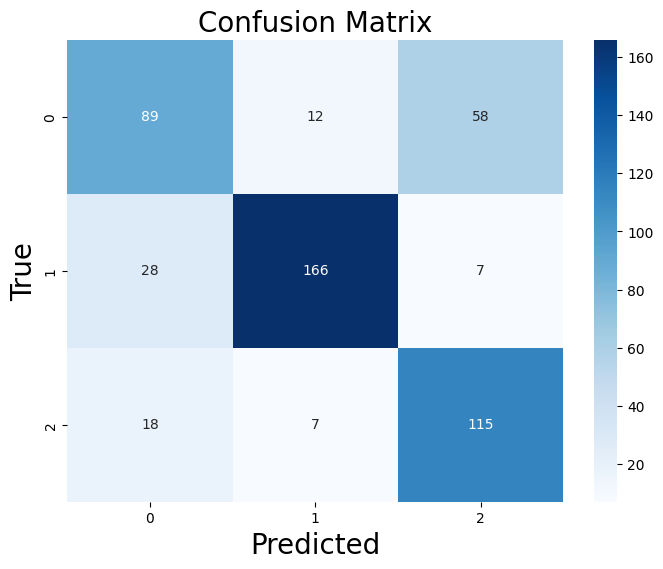

Top-1 Accuracy (R1 score): 74.00%


In [15]:
conf_matrix = confusion_matrix(predictions, q_test_y[: NUM_SAMPLES * 10])

# Graficar la matriz de confusión utilizando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=sorted(NUMS_TO_INCLUDE),
    yticklabels=sorted(NUMS_TO_INCLUDE),
)
plt.title("Confusion Matrix", size=20)
plt.xlabel("Predicted", size=20)
plt.ylabel("True", size=20)
plt.show()

# Calcular y mostrar la precisión Top-1 (Recall a Rank 1)
top_1_accuracy = np.mean(predictions == q_test_y[: NUM_SAMPLES * 10])
print(f"Top-1 Accuracy (R1 score): {top_1_accuracy * 100:.2f}%")

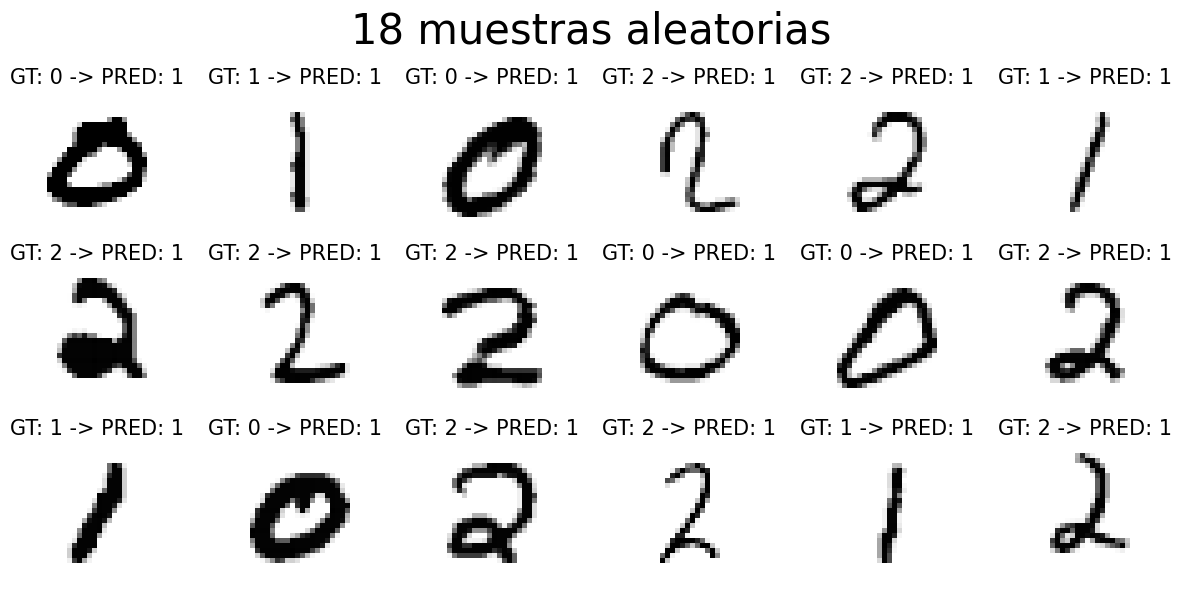

In [16]:
# Se muestran muestras aleatorias del conjunto de prueba junto con la etiqueta real y la predicción
cols = 6
rows = 3
pred_ = np.argmax(vqc.predict_proba(q_test_X[idx]), axis=1)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

for ax in axes.flat:
    idx = random.randint(
        0, q_test_y.shape[0] - 1
    )  # Seleccionar un índice aleatorio válido
    ax.imshow(test_X[idx], cmap="Greys")  # Mostrar la imagen en escala de grises
    # Título que indica la etiqueta verdadera (GT) y la predicha (PRED)
    ax.set_title(
        f"GT: {test_y[idx]} -> PRED: {pred_[0]}",
        size=15,
    )
    ax.axis("off")  # Ocultar ejes

fig.suptitle(f"{cols * rows} muestras aleatorias", size=30)
plt.tight_layout()
plt.show()

## Referencias
[1] PCA - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

[2] Pipeline - https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

[3] docs/tutorials/02_neural_network_classifier_and_regressor.ipynb - https://github.com/qiskit-community/qiskit-machine-learning/blob/stable/0.8/docs/tutorials/02_neural_network_classifier_and_regressor.ipynb

[4] Neural Network Classifier & Regressor - https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

[5] What is principal component analysis (PCA)? - https://www.ibm.com/think/topics/principal-component-analysis